# Devon Biere D195 Capstone - US Electric Car Registrations & Renewable Energy Production by State (2018)

## Research Question

Is there a correlation in the United States between modern renewable electricity production and the adoption of electric cars at the state level? The hypothesis is that there is a positive correlation and that higher volumes of clean energy production will be associated with higher rates of EV registrations.

## Project Approach

- Download, filter, and combine US Government data for 3 data sources:
    - 2018 total vehicle registrations by state (US Department of Transportation)
    - 2018 electric vehicle (EV) registrations by state (US Department of Energy)
    - 1990-2019 annual electric energy production sources by state (US Energy Information Administration)
        - Limit to 2018 year to match available auto registration data
- Per the project requirements, limit the definition of "clean/renewable energy" sources to solar and wind
- Generate descriptive statistics and perform exploratory data analysis
- Perform linear regression analysis to examine the potential correlation between renewable electricity sources as the percentage of total megawatts produced in a state and the target variable, EVs as a percentage of total car registrations in a state

## Project/Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import statsmodels.api as sm

%pylab inline

# Data sources
INPUT_POWER_DATA_FILENAME = 'States_Annual_Energy_Generation_Sources_1990_2019.xlsx'
INPUT_ALL_REGISTRATIONS_FILENAME = 'States_All_Vehicle_Registrations_2018.xlsx'
INPUT_EV_REGISTRATIONS_FILENAME = 'States_Electric_Vehicle_Registrations_2018.xlsx'

# Reference data
INPUT_STATE_CODES_FILENAME = 'state_codes.xlsx'
df_state_codes = pd.read_excel(INPUT_STATE_CODES_FILENAME)

# Formatting options
plt.rcParams['figure.dpi'] = 100
format_cols = {
    'mw_total': '{:,.0f}',
    'mw_clean': '{:,.0f}',
    'mw_solar': '{:,.0f}',
    'mw_wind': '{:,.0f}',
    'ev_cars': '{:,.0f}',
    'total_cars': '{:,.0f}',
    'pct_power_clean': '{:.3%}',
    'pct_power_solar': '{:.3%}',
    'pct_power_wind': '{:.3%}',
    'pct_ev_cars': '{:.3%}',
    'pct_clean_ev_gap': '{:.3%}'
}

def format_as_millions(val, position):
    return '%1.1fM' % (val*1e-6)

Populating the interactive namespace from numpy and matplotlib


## Electrical Power Sources by State

In [2]:
df_power = pd.read_excel(INPUT_POWER_DATA_FILENAME,
                         header=None,
                         usecols='A:E',
                         skiprows=2,
                         names=['year', 'state_code', 'producer_type', 'energy_source', 'mw']
                        )

In [4]:
df_power['producer_type'].value_counts()

Total Electric Power Industry                       14783
Electric Generators, Electric Utilities             10602
Combined Heat and Power, Industrial Power            8989
Electric Generators, Independent Power Producers     8535
Combined Heat and Power, Commercial Power            5653
Combined Heat and Power, Electric Power              5194
Name: producer_type, dtype: int64

In [5]:
df_power[df_power['state_code'].map(len) != 2]['state_code'].value_counts()

US-TOTAL    1460
US-Total     585
Name: state_code, dtype: int64

In [6]:
# Drop DC as it has no wind or solar power as of 2018
df_power = df_power[(df_power['state_code'] != 'DC')]

# Keep only total electric power
df_power = df_power[(df_power['producer_type'] == 'Total Electric Power Industry')]

# Keep only 2-char states (remove US-Total variants)
df_power = df_power[df_power['state_code'].map(len) == 2]

# Convert megawatts column to int
df_power['mw'] = df_power['mw'].astype('int64')

# Keep only 2018
df_power = df_power[df_power['year'] == 2018]
df_power.drop('year', axis='columns', inplace=True) # No longer need year

In [7]:
df_power['energy_source'].value_counts()

Petroleum                         50
Total                             50
Coal                              49
Natural Gas                       49
Hydroelectric Conventional        48
Other                             48
Other Biomass                     47
Solar Thermal and Photovoltaic    46
Wind                              41
Wood and Wood Derived Fuels       39
Nuclear                           30
Other Gases                       22
Pumped Storage                    18
Geothermal                         7
Name: energy_source, dtype: int64

In [8]:
# Pivot to express energy source rows as columns
df_power_pivot = df_power.pivot_table(values='mw', 
                                      index=['state_code'],
                                      columns='energy_source',
                                      fill_value=0,
                                      dropna = True
                                     )

# Remove energy types we're not interested in for this analysis
df_power_pivot.drop(columns=['Coal',
                             'Geothermal', 
                             'Hydroelectric Conventional',
                             'Natural Gas',
                             'Nuclear',
                             'Other',
                             'Other Biomass',
                             'Other Gases',
                             'Petroleum',
                             'Pumped Storage',
                             'Wood and Wood Derived Fuels'
                            ], inplace=True)

# Clean up names
df_power_pivot.rename(columns={'Solar Thermal and Photovoltaic': 'mw_solar',
                               'Wind': 'mw_wind',
                               'Total': 'mw_total'
                              }, inplace=True)

# Derive additional stats/percentages
df_power_pivot['mw_clean'] = df_power_pivot['mw_solar'] + df_power_pivot['mw_wind']
df_power_pivot['pct_power_clean'] = df_power_pivot['mw_clean'] / df_power_pivot['mw_total']
df_power_pivot['pct_power_solar'] = df_power_pivot['mw_solar'] / df_power_pivot['mw_total']
df_power_pivot['pct_power_wind'] = df_power_pivot['mw_wind'] / df_power_pivot['mw_total']

# Re-order columns and reset index
df_power_pivot = df_power_pivot.reindex(columns=['mw_total', 'mw_clean', 'mw_solar', 'mw_wind', 
                                'pct_power_clean', 'pct_power_solar', 'pct_power_wind'])
df_power_pivot.reset_index(inplace=True)

# Add electricity generation data to final dataframe
df_final = pd.merge(df_state_codes, df_power_pivot, on='state_code')

# Sort
df_final.sort_values('state_code', inplace=True)

# Drop extra megawatt energy production columns
df_final.drop(columns=['mw_clean', 'mw_solar', 'mw_wind'], inplace=True)

## State Electric Vehicle Registrations

In [9]:
# Load state EV registration data
df_ev_reg = pd.read_excel(INPUT_EV_REGISTRATIONS_FILENAME,
                          header = None,
                          usecols = 'B,C',
                          skiprows = 3,
                          names = ['state_name', 'ev_cars'])

# Cleanup
df_ev_reg = df_ev_reg[df_ev_reg['state_name'] != 'Total']
df_ev_reg = df_ev_reg[(df_ev_reg['state_name'] != 'District of Columbia')]
df_ev_reg['ev_cars'] = df_ev_reg['ev_cars'].astype('int64')

In [10]:
# Load state total car registrations
df_all_reg = pd.read_excel(INPUT_ALL_REGISTRATIONS_FILENAME,
                           header = None,
                           usecols = 'A,D',
                           skiprows = 12,
                           names = ['state_name', 'total_cars'])

# Cleanup
df_all_reg.dropna(inplace=True)
df_all_reg = df_all_reg[df_all_reg['state_name'] != 'Total']
df_all_reg['total_cars'] = df_all_reg['total_cars'].astype('int64')
df_all_reg['state_name'] = df_all_reg['state_name'].str.rstrip(" (2)")
df_all_reg = df_all_reg[(df_all_reg['state_name'] != 'Dist. of Col.')]

In [11]:
# Combine (all) registration data with state code ref data
df_reg = pd.merge(df_state_codes, df_all_reg, on='state_name')

# Combine (all) registration data with EV data
df_reg = pd.merge(df_reg, df_ev_reg, on='state_name')
df_reg.drop(columns=['state_name'], inplace=True)

# Calculate % of EV registrations
df_reg['pct_ev_cars'] = df_reg['ev_cars'] / df_reg['total_cars']
df_reg.sort_values('state_code', inplace=True)

# Combine all registration data with state power data
df_final = pd.merge(df_final, df_reg, on='state_code')

## Final Combined Dataset

In [12]:
df_final.count()

state_code         50
state_name         50
mw_total           50
pct_power_clean    50
pct_power_solar    50
pct_power_wind     50
total_cars         50
ev_cars            50
pct_ev_cars        50
dtype: int64

In [13]:
df_final.style.format(format_cols).hide_index()

state_code,state_name,mw_total,pct_power_clean,pct_power_solar,pct_power_wind,total_cars,ev_cars,pct_ev_cars
AK,Alaska,"6,247,359",2.481%,0.000%,2.481%,"183,270",530,0.289%
AL,Alabama,"145,057,994",0.246%,0.246%,0.000%,"2,161,212","1,450",0.067%
AR,Arkansas,"67,999,352",0.299%,0.299%,0.000%,"921,161",520,0.056%
AZ,Arizona,"111,925,144",5.066%,4.593%,0.474%,"2,391,772","15,000",0.627%
CA,California,"195,465,638",20.980%,13.806%,7.175%,"15,065,827","256,800",1.705%
CO,Colorado,"55,386,279",19.513%,1.918%,17.595%,"1,798,177","11,700",0.651%
CT,Connecticut,"39,453,552",0.299%,0.268%,0.031%,"1,306,709","4,450",0.341%
DE,Delaware,"6,240,644",0.881%,0.798%,0.083%,"433,363",720,0.166%
FL,Florida,"244,252,035",0.988%,0.988%,0.000%,"7,966,091","25,200",0.316%
GA,Georgia,"129,239,371",1.544%,1.544%,0.000%,"3,557,469","15,300",0.430%


## Reporting - Electrical Power Sources

In [14]:
median_pct_power_clean = df_final['pct_power_clean'].median()
print("Median % of power from clean (solar & wind) sources in state: " + '{:.3%}'.format(median_pct_power_clean))

Median % of power from clean (solar & wind) sources in state: 4.884%


In [15]:
print("10 States with Highest % of Clean Electricity Sources")
df_final.nlargest(10, 'pct_power_clean')[['state_code', 
                                          'state_name', 
                                          'pct_power_clean', 
                                          'pct_power_solar', 
                                          'pct_power_wind']] \
    .style.format(format_cols).hide_index() \
    .set_properties(color='green', subset=['pct_power_clean', 'pct_power_solar', 'pct_power_wind']) \
    .set_properties(**{'background-color':'lemonchiffon'}, subset=['pct_power_clean'])

10 States with Highest % of Clean Electricity Sources


state_code,state_name,pct_power_clean,pct_power_solar,pct_power_wind
KS,Kansas,36.579%,0.015%,36.564%
IA,Iowa,33.678%,0.018%,33.660%
OK,Oklahoma,31.778%,0.071%,31.706%
ND,North Dakota,25.186%,0.000%,25.186%
NM,New Mexico,22.771%,4.127%,18.644%
SD,South Dakota,22.484%,0.013%,22.471%
VT,Vermont,22.033%,4.899%,17.134%
ME,Maine,21.243%,0.107%,21.136%
CA,California,20.980%,13.806%,7.175%
CO,Colorado,19.513%,1.918%,17.595%


In [16]:
print("10 States with Lowest % of Clean Electricity Sources")
df_final.nsmallest(10, 'pct_power_clean')[['state_code', 
                                          'state_name', 
                                          'pct_power_clean', 
                                          'pct_power_solar', 
                                          'pct_power_wind']] \
    .style.format(format_cols).hide_index() \
    .set_properties(color='green', subset=['pct_power_clean', 'pct_power_solar', 'pct_power_wind']) \
    .set_properties(**{'background-color':'lemonchiffon'}, subset=['pct_power_clean'])

10 States with Lowest % of Clean Electricity Sources


state_code,state_name,pct_power_clean,pct_power_solar,pct_power_wind
LA,Louisiana,0.001%,0.001%,0.000%
KY,Kentucky,0.050%,0.050%,0.000%
AL,Alabama,0.246%,0.246%,0.000%
TN,Tennessee,0.256%,0.205%,0.050%
CT,Connecticut,0.299%,0.268%,0.031%
AR,Arkansas,0.299%,0.299%,0.000%
MS,Mississippi,0.513%,0.513%,0.000%
SC,South Carolina,0.514%,0.514%,0.000%
VA,Virginia,0.799%,0.799%,0.000%
DE,Delaware,0.881%,0.798%,0.083%


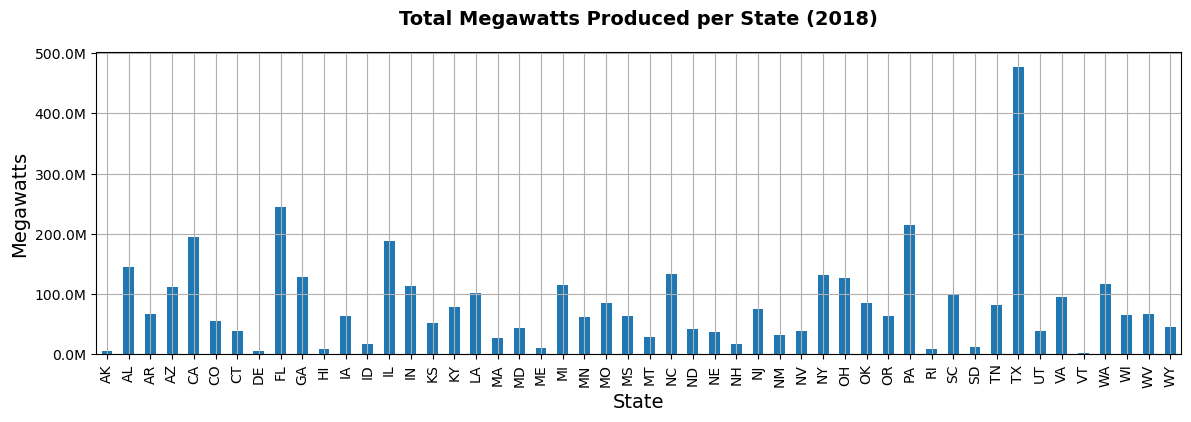

In [17]:
df_final.plot(x='state_code', y='mw_total', kind='bar', figsize=(14, 4), grid=True, legend=None)
plt.title('Total Megawatts Produced per State (2018)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('State', size=14)
plt.ylabel('Megawatts', size=14)
plt.gca().yaxis.set_major_formatter(format_as_millions)

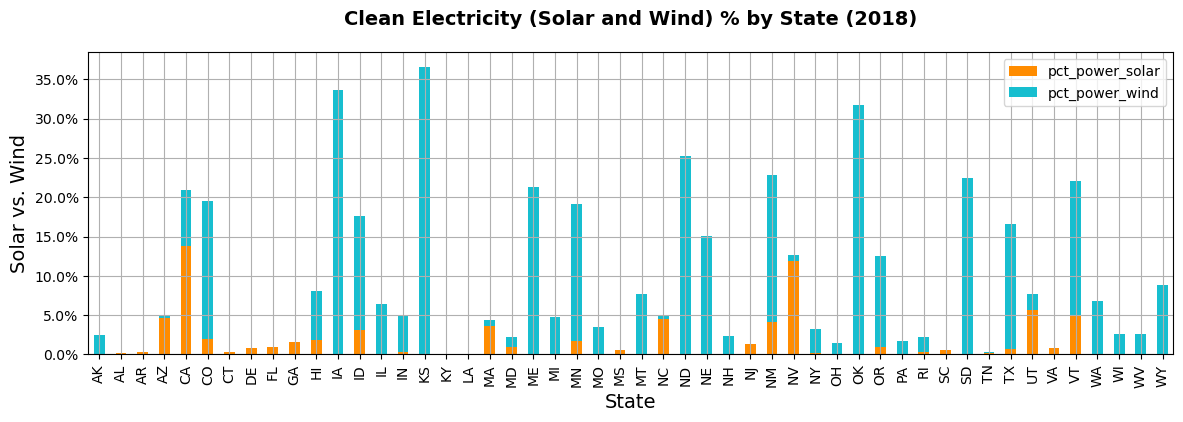

In [18]:
df_final.plot(x='state_code', 
              y=['pct_power_solar', 'pct_power_wind'], 
              kind='bar',
              stacked=True,
              figsize=(14, 4), 
              grid=True,
              color=['darkorange', 'tab:cyan']
             )
plt.title('Clean Electricity (Solar and Wind) % by State (2018)', fontsize=14, fontweight='bold', pad='20')
plt.xlabel('State', size=14)
plt.ylabel('Solar vs. Wind', size=14)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
axes = plt.gca()

## Reporting - Total Car Registrations

In [19]:
median_total_cars = df_final['total_cars'].median()
print("Median # of cars registered per state: " + '{:,.0f}'.format(median_total_cars))

Median # of cars registered per state: 1,605,282


In [20]:
print("10 states with highest number of registered cars")
df_final.nlargest(10, 'total_cars')[['state_code', 'state_name', 'total_cars']] \
    .style.format(format_cols).hide_index()

10 states with highest number of registered cars


state_code,state_name,total_cars
CA,California,"15,065,827"
TX,Texas,"8,248,322"
FL,Florida,"7,966,091"
NY,New York,"4,712,779"
OH,Ohio,"4,603,594"
IL,Illinois,"4,477,763"
PA,Pennsylvania,"4,424,183"
GA,Georgia,"3,557,469"
NC,North Carolina,"3,393,781"
VA,Virginia,"3,267,735"


In [21]:
print("10 states with lowest number of registered cars")
df_final.nsmallest(10, 'total_cars')[['state_code', 'state_name', 'total_cars']] \
    .style.format(format_cols).hide_index()

10 states with lowest number of registered cars


state_code,state_name,total_cars
AK,Alaska,"183,270"
WY,Wyoming,"203,546"
VT,Vermont,"218,302"
ND,North Dakota,"240,048"
SD,South Dakota,"358,859"
ME,Maine,"390,506"
RI,Rhode Island,"412,255"
DE,Delaware,"433,363"
MT,Montana,"452,845"
NH,New Hampshire,"506,959"


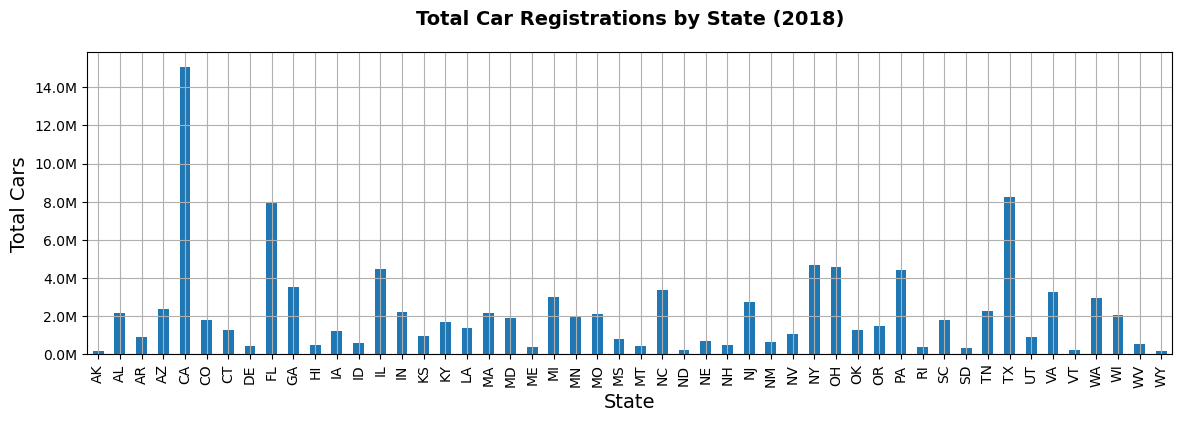

In [22]:
df_final.plot(x='state_code', y='total_cars', kind='bar', figsize=(14, 4), grid=True, legend=None)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_as_millions))

plt.title('Total Car Registrations by State (2018)', fontsize=14, fontweight='bold', pad='20')
plt.xlabel('State', size=14)
o = plt.ylabel('Total Cars', size=14)

## Reporting - EV Registrations

In [23]:
median_pct_ev_cars = df_final['pct_ev_cars'].median()
print("Median % EV registrations at state level: " + '{:.3%}'.format(median_pct_ev_cars))

Median % EV registrations at state level: 0.192%


In [24]:
print("10 states with highest % of EV car registrations")
df_final.nlargest(10, 'pct_ev_cars')[['state_code', 'state_name', 'pct_ev_cars']] \
    .style.format(format_cols).hide_index()

10 states with highest % of EV car registrations


state_code,state_name,pct_ev_cars
CA,California,1.705%
HI,Hawaii,1.293%
WA,Washington,0.958%
OR,Oregon,0.833%
CO,Colorado,0.651%
AZ,Arizona,0.627%
UT,Utah,0.557%
VT,Vermont,0.486%
NV,Nevada,0.448%
MA,Massachusetts,0.447%


In [25]:
print("10 states with lowest % of EV car registrations")
df_final.nsmallest(10, 'pct_ev_cars')[['state_code', 'state_name', 'pct_ev_cars']] \
    .style.format(format_cols).hide_index()

10 states with lowest % of EV car registrations


state_code,state_name,pct_ev_cars
WV,West Virginia,0.041%
MS,Mississippi,0.047%
AR,Arkansas,0.056%
AL,Alabama,0.067%
ND,North Dakota,0.071%
KY,Kentucky,0.072%
SD,South Dakota,0.072%
LA,Louisiana,0.080%
WY,Wyoming,0.084%
IA,Iowa,0.088%


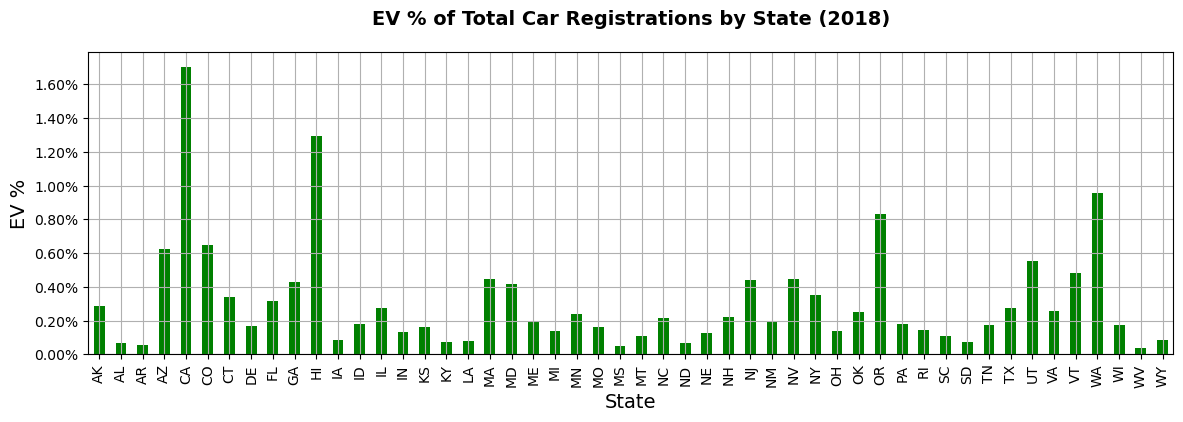

In [26]:
df_final.plot(x='state_code', y='pct_ev_cars', kind='bar', figsize=(14, 4), grid=True, legend=None, color='green')
plt.title('EV % of Total Car Registrations by State (2018)', fontsize=14, fontweight='bold', pad='20')
plt.xlabel('State', size=14)
plt.ylabel('EV %', size=14)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

## Reporting - Clean Energy Sources and EV Registrations

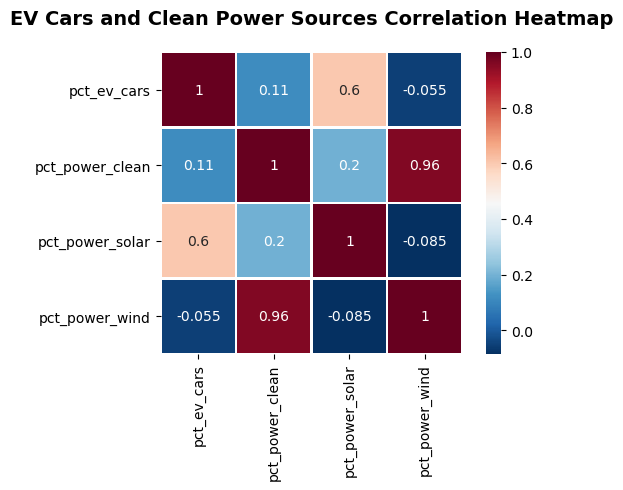

In [27]:
heatmap = sns.heatmap(df_final[['pct_ev_cars', 'pct_power_clean', 'pct_power_solar', 'pct_power_wind']].corr(), 
                      cmap='RdBu_r', 
                      annot=True,
                      square=True,
                      linewidths=1)
bottom, top = heatmap.get_ylim()
o = heatmap.set_title('EV Cars and Clean Power Sources Correlation Heatmap', 
                            fontsize=14, fontweight='bold', pad='20')

## Pearson's r Correlation Coefficients

In [28]:
r = np.corrcoef(df_final['pct_power_clean'], df_final['pct_ev_cars'])
print("Clean Power and EV Car Registrations, r = " + '{:.4}'.format(r[0, 1]))

r = np.corrcoef(df_final['pct_power_solar'], df_final['pct_ev_cars'])
print("Solar Power and EV Car Registrations, r = " + '{:.4}'.format(r[0, 1]))

r = np.corrcoef(df_final['pct_power_wind'], df_final['pct_ev_cars'])
print("Wind Power and EV Car Registrations, r = " + '{:.4}'.format(r[0, 1]))

Clean Power and EV Car Registrations, r = 0.1147
Solar Power and EV Car Registrations, r = 0.6017
Wind Power and EV Car Registrations, r = -0.05488


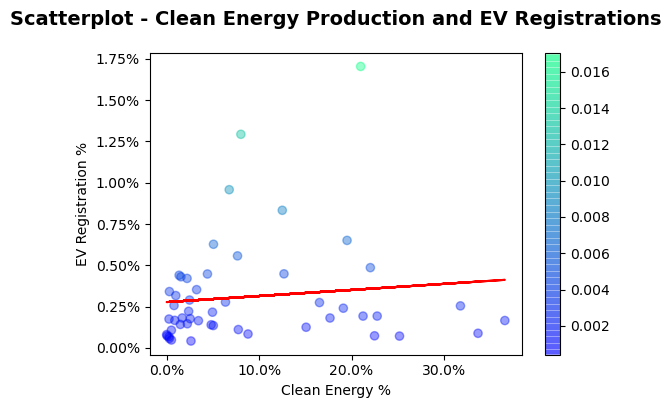

In [29]:
x = df_final['pct_power_clean']
y = df_final['pct_ev_cars']
plt.scatter(x, y, c=y, cmap='winter', alpha=0.4)
plt.title('Scatterplot - Clean Energy Production and EV Registrations', fontsize=14, fontweight='bold', pad='20')
plt.xlabel('Clean Energy %')
plt.ylabel('EV Registration %')
plt.colorbar()
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

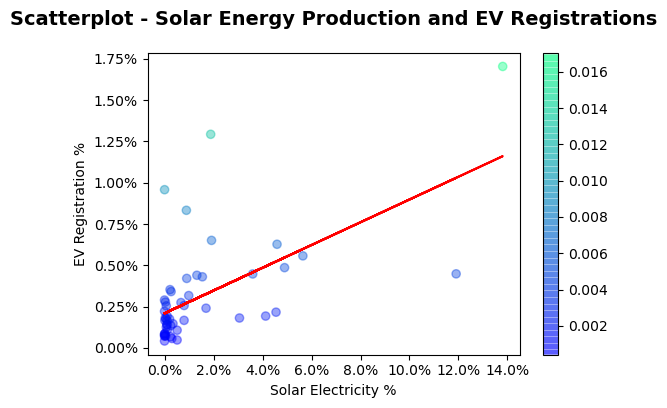

In [30]:
x = df_final['pct_power_solar']
y = df_final['pct_ev_cars']
plt.scatter(x, y, c=y, cmap='winter', alpha=0.4)
plt.title('Scatterplot - Solar Energy Production and EV Registrations', 
          fontsize=14, fontweight='bold', pad='20')
plt.xlabel('Solar Electricity %')
plt.ylabel('EV Registration %')
plt.colorbar()
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

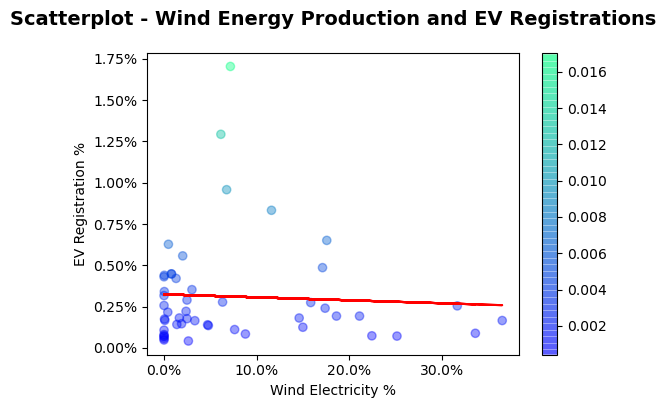

In [31]:
x = df_final['pct_power_wind']
y = df_final['pct_ev_cars']
plt.scatter(x, y, c=y, cmap='winter', alpha=0.4)
plt.title('Scatterplot - Wind Energy Production and EV Registrations', fontsize=14, fontweight='bold', pad='20')
plt.xlabel('Wind Electricity %')
plt.ylabel('EV Registration %')
plt.colorbar()
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

## Linear Regression Model - EV and Clean Energy Source

In [32]:
x = df_final[['pct_power_solar', 'pct_power_wind']] # Features, independent variables     
y = df_final['pct_ev_cars'] # Target, dependent variable
x = sm.add_constant(x)
lr_results = sm.OLS(y, x).fit()
lr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pct_ev_cars   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     13.34
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           2.59e-05
Time:                        20:07:26   Log-Likelihood:                 228.07
No. Observations:                  50   AIC:                            -450.1
Df Residuals:                      47   BIC:                            -444.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0021      0.001      4.056      0.000       0.001       0.003
pct_power_solar     0.0689      0.013      5.143      0.000       0.042       0.096
pct_power_wind     -0.0001      0.004     -0.033      0.974      -0.008       0.008
==============================================================================
Omnibus:                       28.992   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.736
Skew:                           1.684   Prob(JB):                     3.93e-14
Kurtosis:                       7.276   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Possible Opportunity: Cleanest Electricity States with Lowest EV %

In [33]:
df_final['pct_clean_ev_gap'] = df_final['pct_power_clean'] - df_final['pct_ev_cars']
df_pct_clean_ev_gap = df_final[['state_code', 'state_name', 
                                'pct_clean_ev_gap', 
                                'pct_power_clean', 
                                'pct_ev_cars']].copy()
df_pct_clean_ev_gap.sort_values('pct_clean_ev_gap', ascending=False, inplace=True)

In [34]:
df_pct_clean_ev_gap.head(20) \
    .style.format(format_cols).hide_index() \
    .set_properties(**{'background-color':'lemonchiffon'}, subset=['pct_clean_ev_gap'])

state_code,state_name,pct_clean_ev_gap,pct_power_clean,pct_ev_cars
KS,Kansas,36.414%,36.579%,0.165%
IA,Iowa,33.591%,33.678%,0.088%
OK,Oklahoma,31.524%,31.778%,0.254%
ND,North Dakota,25.115%,25.186%,0.071%
NM,New Mexico,22.579%,22.771%,0.192%
SD,South Dakota,22.412%,22.484%,0.072%
VT,Vermont,21.548%,22.033%,0.486%
ME,Maine,21.051%,21.243%,0.192%
CA,California,19.276%,20.980%,1.705%
MN,Minnesota,18.870%,19.109%,0.240%


## Export Final Dataset

In [35]:
df_final.to_excel('Devon_Biere_D195_Capstone_Final_Data.xlsx', sheet_name='Output', index=False)

## Findings

- In the United States, renewable electricity production (solar and wind combined) has a very low degree of correlation with electric car registrations (r = 0.1147).
- When examining solar power and wind power usage individually against the EV registration percentage at the state level, the following have been demonstrated with statistical significance:
    - Solar power has a moderately high degree of correlation to electric car registrations (r = 0.6017).
    - Wind power has no meaningful correlation to EV car registrations (r = -0.05488).